In [1]:
from pyhdf.SD import SD, SDC
import numpy as np
import pyproj
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [2]:
valid_range = [-2000, 10000]
fill_value = -3000
scale = 0.0001

In [3]:
file = SD("data/MOD13Q1.A2025017.h18v04.061.2025035164158.hdf", SDC.READ)

In [ ]:
gridmeta = file.attributes()["StructMetadata.0"]
gridmeta = dict([x.split("=") for x in gridmeta.split() if "=" in x])

for key, val in gridmeta.items():
    try:
        gridmeta[key] = eval(val)
    except:
        pass
gridmeta

{'GROUP': 'PointStructure',
 'END_GROUP': 'PointStructure',
 'GridName': '"MODIS_Grid_16DAY_250m_500m_VI"',
 'XDim': '4800',
 'YDim': '4800',
 'UpperLeftPointMtrs': '(0.000000,5559752.598333)',
 'LowerRightMtrs': '(1111950.519667,4447802.078667)',
 'Projection': 'GCTP_SNSOID',
 'ProjParams': '(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)',
 'SphereCode': '-1',
 'OBJECT': 'DataField_12',
 'DataFieldName': '"250m',
 'DataType': 'DFNT_INT8',
 'DimList': '("YDim","XDim")',
 'END_OBJECT': 'DataField_12'}

In [5]:
datasets_dic = file.datasets()
for idx, sds in enumerate(datasets_dic.keys()):
    print(idx, sds)

0 250m 16 days NDVI
1 250m 16 days EVI
2 250m 16 days VI Quality
3 250m 16 days red reflectance
4 250m 16 days NIR reflectance
5 250m 16 days blue reflectance
6 250m 16 days MIR reflectance
7 250m 16 days view zenith angle
8 250m 16 days sun zenith angle
9 250m 16 days relative azimuth angle
10 250m 16 days composite day of the year
11 250m 16 days pixel reliability


In [6]:
sds_obj = file.select('250m 16 days EVI') # select sds
data = sds_obj.get() # get sds data
data = data.astype(float)
print(sds_obj)
print(data.shape)
print(data)

(4800, 4800)
[[-3000. -3000. -3000. ...  2555.   859.  1625.]
 [-3000. -3000. -3000. ...  1264.  1572.  2151.]
 [-3000. -3000. -3000. ...  1098.  1847.  2267.]
 ...
 [ 3603.  2927.  3086. ... -3000. -3000. -3000.]
 [ 3397.  2778.  2165. ... -3000. -3000. -3000.]
 [ 2653.  2477.  2379. ... -3000. -3000. -3000.]]


In [7]:
# Apply the attributes to the data.
invalid = np.logical_or(data < valid_range[0], data > valid_range[1])
invalid = np.logical_or(invalid, data == fill_value)
data[invalid] = np.nan
data = data * scale
data = np.ma.masked_array(data, np.isnan(data))
data

masked_array(
  data=[[--, --, --, ..., 0.2555, 0.0859, 0.1625],
        [--, --, --, ..., 0.1264, 0.1572, 0.2151],
        [--, --, --, ..., 0.10980000000000001, 0.1847, 0.2267],
        ...,
        [0.3603, 0.2927, 0.30860000000000004, ..., --, --, --],
        [0.3397, 0.2778, 0.2165, ..., --, --, --],
        [0.26530000000000004, 0.2477, 0.2379, ..., --, --, --]],
  mask=[[ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=1e+20)

In [26]:
x0 = gridmeta["UpperLeftPointMtrs"][0]
y0 = gridmeta["UpperLeftPointMtrs"][1]
x1 = gridmeta["LowerRightMtrs"][0]
y1 = gridmeta["LowerRightMtrs"][1]
nx, ny = data.shape

In [27]:
x = np.linspace(x0, x1, nx, endpoint=False)
y = np.linspace(y0, y1, ny, endpoint=False)
xv, yv = np.meshgrid(x, y)

In [34]:
sinu = pyproj.Proj(f"+proj=sinu +R={gridmeta["ProjParams"][0]} +nadgrids=@null +wktext") 
wgs84 = pyproj.Proj("+init=EPSG:4326") 
lon, lat= pyproj.transform(sinu, wgs84, xv, yv)

c:\Users\alexl\miniconda3\envs\conda-env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\alexl\AppData\Local\Temp\ipykernel_10364\3850484438.py:3: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat= pyproj.transform(sinu, wgs84, xv, yv)


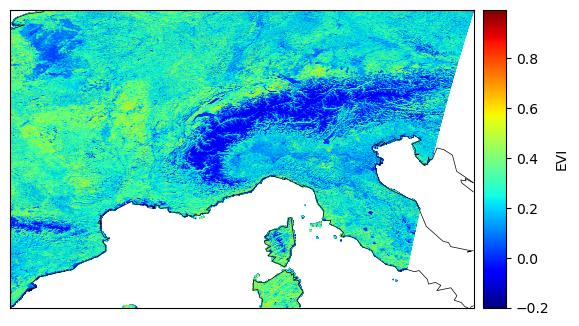

In [35]:
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=np.min(lat),  urcrnrlat=np.max(lat),
            llcrnrlon=np.min(lon), urcrnrlon=np.max(lon))
m.drawcoastlines(linewidth=0.5)
m.scatter(lon, lat, c=data, s=1, cmap=plt.cm.jet,
          edgecolors=None, linewidth=0)
cb = m.colorbar()
cb.set_label("EVI")
plt.show()